In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, ndimage

## Define functions

### Generating rw

In [2]:
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def sample_wave(r_grid,k_mean,k_cov,n_wave = 100):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov)
        k_dot_r = np.sum([r_grid[x]*k_sample[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

# Misoientation
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi_r) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def sample_wave_MO_complex(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def sample_wave_MO_complex_belt(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arcsin(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

In [3]:
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

@dataclass
class DiscreteGradient3D:
    shape_ref: Tuple[int, int, int]
    pair: np.ndarray
    critical: np.ndarray
    dim: np.ndarray
    value: np.ndarray


def func_field_grad(field: np.ndarray, *, sos_eps: float = 1e-12) -> DiscreteGradient3D:
    """
    Gyulassy'08 discrete gradient on refined grid:
      - sort by (dim, value)
      - value of higher-dim cells = max(incident vertex values)
      - pair alpha if it's the only unassigned facet of some unassigned cofacet beta
      - choose beta by steepest descent (min beta value)
      - improved SOS to reduce zero-persistence criticals in flats
    """
    if field.ndim != 3:
        raise ValueError("field must be a 3D array (nx, ny, nz).")
    nx, ny, nz = field.shape

    rx, ry, rz = 2 * nx - 1, 2 * ny - 1, 2 * nz - 1
    shape_ref = (rx, ry, rz)

    ii, jj, kk = np.indices(shape_ref)
    dim = ((ii & 1) + (jj & 1) + (kk & 1)).astype(np.uint8)

    # ---- CHANGED: SOS on vertices only (then lift by max to higher cells) ----
    val = np.full(shape_ref, np.nan, dtype=np.float64)
    rank = (ii.astype(np.float64) * (ry * rz) + jj.astype(np.float64) * rz + kk.astype(np.float64))

    v = field.astype(np.float64, copy=False)
    val[0::2, 0::2, 0::2] = v + sos_eps * rank[0::2, 0::2, 0::2]

    def incident_vertices(i: int, j: int, k: int) -> List[Tuple[int, int, int]]:
        xs = [i] if (i & 1) == 0 else [i - 1, i + 1]
        ys = [j] if (j & 1) == 0 else [j - 1, j + 1]
        zs = [k] if (k & 1) == 0 else [k - 1, k + 1]
        out = []
        for x in xs:
            for y in ys:
                for z in zs:
                    if 0 <= x < rx and 0 <= y < ry and 0 <= z < rz:
                        out.append((x, y, z))
        return out

    # lift: cell value = max incident vertex value
    for i in range(rx):
        for j in range(ry):
            for k in range(rz):
                if ((i & 1) == 0) and ((j & 1) == 0) and ((k & 1) == 0):
                    continue
                verts = incident_vertices(i, j, k)
                if verts:
                    val[i, j, k] = max(val[x, y, z] for (x, y, z) in verts)

    pair = np.full(shape_ref, -1, dtype=np.int64)
    assigned = np.zeros(shape_ref, dtype=bool)

    def lin(i: int, j: int, k: int) -> int:
        return (i * ry + j) * rz + k

    def unlin(a: int) -> Tuple[int, int, int]:
        i = a // (ry * rz)
        rem = a - i * (ry * rz)
        j = rem // rz
        k = rem - j * rz
        return int(i), int(j), int(k)

    steps = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]

    def cofacets(i: int, j: int, k: int):
        d0 = dim[i, j, k]
        out = []
        for di, dj, dk in steps:
            ni, nj, nk = i + di, j + dj, k + dk
            if 0 <= ni < rx and 0 <= nj < ry and 0 <= nk < rz and dim[ni, nj, nk] == d0 + 1:
                out.append((ni, nj, nk))
        return out

    def facets(i: int, j: int, k: int):
        d0 = dim[i, j, k]
        out = []
        for di, dj, dk in steps:
            ni, nj, nk = i + di, j + dj, k + dk
            if 0 <= ni < rx and 0 <= nj < ry and 0 <= nk < rz and dim[ni, nj, nk] == d0 - 1:
                out.append((ni, nj, nk))
        return out

    # order: increasing dim, then increasing value
    order = np.lexsort((val.ravel(), dim.ravel()))

    for a in order:
        i, j, k = unlin(int(a))
        if assigned[i, j, k]:
            continue

        candidates = []
        for (bi, bj, bk) in cofacets(i, j, k):
            if assigned[bi, bj, bk]:
                continue
            # count unassigned facets of beta
            un_facets = 0
            only_is_a = False
            for (fi, fj, fk) in facets(bi, bj, bk):
                if not assigned[fi, fj, fk]:
                    un_facets += 1
                    if (fi, fj, fk) == (i, j, k):
                        only_is_a = True
            if un_facets == 1 and only_is_a:
                # ---- CHANGED: stable tie-break by (beta value, beta rank) ----
                candidates.append((val[bi, bj, bk], rank[bi, bj, bk], bi, bj, bk))

        if candidates:
            _, _, bi, bj, bk = min(candidates)
            pair[i, j, k] = lin(bi, bj, bk)
            pair[bi, bj, bk] = lin(i, j, k)
            assigned[i, j, k] = True
            assigned[bi, bj, bk] = True
        else:
            assigned[i, j, k] = True

    critical = (pair < 0)
    return DiscreteGradient3D(shape_ref, pair, critical, dim, val)


In [4]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Set, Optional
import numpy as np

@dataclass
class Node:
    nid: int
    cell_ijk: Tuple[int, int, int]
    dim: int
    value: float
    pos: Tuple[float, float, float]

@dataclass
class Arc:
    src: int
    dst: int
    src_dim: int
    dst_dim: int
    geom: List[Tuple[float, float, float]]

@dataclass
class OneMSC:
    nodes: Dict[int, Node]
    arcs: List[Arc]
    cell_to_nid: Dict[Tuple[int,int,int], int]


def func_dg_1ms(
    dg: DiscreteGradient3D,
    *,
    periodic: bool = False,
    drop_exact_duplicate_geometry: bool = False,
) -> OneMSC:
    """
    Build the 1-skeleton of the discrete Morse–Smale complex from a discrete gradient.
    Nodes: barycenters of critical cells.
    Arcs: V-paths connecting critical cells with index difference 1.

    periodic=True enables PBC on the refined grid (wrap neighbors).
    """
    pair = dg.pair
    crit = dg.critical
    dim  = dg.dim
    val  = dg.value
    rx, ry, rz = dg.shape_ref

    def wrap(i: int, n: int) -> int:
        return i % n

    def inb(i: int, n: int) -> bool:
        return 0 <= i < n

    def unlin(a: int) -> Tuple[int, int, int]:
        i = a // (ry * rz)
        rem = a - i * (ry * rz)
        j = rem // rz
        k = rem - j * rz
        return int(i), int(j), int(k)

    def barycenter(i: int, j: int, k: int) -> Tuple[float, float, float]:
        # refined grid spacing = 1/2 of original grid spacing
        # NOTE: for periodic viz you may want to "unwrap" later
        return (0.5 * i, 0.5 * j, 0.5 * k)

    steps = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]

    def facets(i: int, j: int, k: int) -> List[Tuple[int,int,int]]:
        """All (d-1)-facets of cell (i,j,k) in refined grid adjacency."""
        d0 = int(dim[i, j, k])
        out = []
        for di, dj, dk in steps:
            ni, nj, nk = i + di, j + dj, k + dk
            if periodic:
                ni, nj, nk = wrap(ni, rx), wrap(nj, ry), wrap(nk, rz)
                if int(dim[ni, nj, nk]) == d0 - 1:
                    out.append((ni, nj, nk))
            else:
                if inb(ni, rx) and inb(nj, ry) and inb(nk, rz):
                    if int(dim[ni, nj, nk]) == d0 - 1:
                        out.append((ni, nj, nk))
        return out

    # ---- nodes: all critical cells ----
    nodes: Dict[int, Node] = {}
    cell_to_nid: Dict[Tuple[int,int,int], int] = {}
    nid = 0
    for (i, j, k) in np.argwhere(crit):
        i, j, k = int(i), int(j), int(k)
        nodes[nid] = Node(
            nid=nid,
            cell_ijk=(i, j, k),
            dim=int(dim[i, j, k]),
            value=float(val[i, j, k]),
            pos=barycenter(i, j, k),
        )
        cell_to_nid[(i, j, k)] = nid
        nid += 1

    # ---- trace V-paths in layer (d-1,d) ----
    def trace_vpaths(alpha0: Tuple[int,int,int], d: int) -> List[List[Tuple[int,int,int]]]:
        """
        Start at alpha0 (dim d-1), alternate via pair(alpha)->beta(d),
        then choose any facet of beta other than entering alpha. Branching allowed.
        """
        paths: List[List[Tuple[int,int,int]]] = []
        stack = [(alpha0, [alpha0])]

        # On a torus, cycles are possible if the pairing has degeneracies.
        # Guard with visited state (alpha, paired_beta) along current path.
        max_steps = rx + ry + rz + 50

        while stack:
            alpha, path = stack.pop()
            ai, aj, ak = alpha

            if crit[ai, aj, ak] and int(dim[ai, aj, ak]) == d - 1:
                paths.append(path)
                continue

            p = int(pair[ai, aj, ak])
            if p < 0:
                continue

            beta = unlin(p)
            bi, bj, bk = beta
            if int(dim[bi, bj, bk]) != d:
                continue

            next_facets = [f for f in facets(bi, bj, bk) if f != alpha]
            if not next_facets:
                continue

            path2 = path + [beta]
            if len(path2) > max_steps:
                continue

            # ---- PBC loop guard: don't revisit same transition repeatedly ----
            # Use last few steps as a cheap cycle detector
            # (stronger: keep a set of (alpha,beta) pairs in this path)
            if periodic:
                # build a path-local visited set once
                visited: Set[Tuple[Tuple[int,int,int], Tuple[int,int,int]]] = set()
                # reconstruct visited from existing path (cost is fine; paths are short)
                for t in range(0, len(path)-1, 2):
                    a_prev = path[t]
                    if t+1 < len(path):
                        b_prev = path[t+1]
                        if isinstance(b_prev, tuple):
                            visited.add((a_prev, b_prev))
                if (alpha, beta) in visited:
                    continue
                visited.add((alpha, beta))

            for fnext in next_facets:
                stack.append((fnext, path2 + [fnext]))

        return paths

    # ---- arcs ----
    arcs: List[Arc] = []
    geom_seen: Optional[Set[Tuple]] = set() if drop_exact_duplicate_geometry else None

    for d in (1, 2, 3):
        for (ci, cj, ck) in np.argwhere(crit & (dim == d)):
            ci, cj, ck = int(ci), int(cj), int(ck)
            src = cell_to_nid[(ci, cj, ck)]

            for alpha0 in facets(ci, cj, ck):
                for path_cells in trace_vpaths(alpha0, d=d):
                    end = path_cells[-1]
                    if end not in cell_to_nid:
                        continue
                    dst = cell_to_nid[end]

                    geom = [barycenter(i, j, k) for (i, j, k) in path_cells]

                    if geom_seen is not None:
                        key = tuple(geom)
                        if key in geom_seen:
                            continue
                        geom_seen.add(key)

                    arcs.append(Arc(
                        src=src,
                        dst=dst,
                        src_dim=int(nodes[src].dim),
                        dst_dim=int(nodes[dst].dim),
                        geom=geom
                    ))

    return OneMSC(nodes=nodes, arcs=arcs, cell_to_nid=cell_to_nid)

In [5]:
from __future__ import annotations
import heapq
from typing import Dict, List, Tuple, Optional, Set
import numpy as np

def func_1ms_simpl(
    msc1: OneMSC,
    eps: float,
    *,
    forbid_boundary: bool = False,
    is_boundary_node: Optional[callable] = None,
    keep_multi_edges: bool = True,
    max_cancellations: Optional[int] = None,
) -> OneMSC:
    """
    Gyulassy'08 persistence simplification on the MS 1-skeleton.

    VALID cancellation iff:
      - dim differs by 1
      - exactly ONE arc connects the pair (no strangulation/pouch)
      - (optional) endpoints not on boundary

    Cancellation:
      - remove nodes l,u and all incident arcs
      - create new arcs from (index i+1 nodes in Nl) to (index i nodes in Nu)
      - new arc geometry inherits/merges geometry from removed arcs
    """
    if forbid_boundary and is_boundary_node is None:
        raise ValueError("If forbid_boundary=True, provide is_boundary_node(node)->bool")

    nodes: Dict[int, Node] = dict(msc1.nodes)
    arcs: List[Arc] = list(msc1.arcs)
    alive = np.ones(len(arcs), dtype=bool)

    # ---- build incidence and multiplicity maps ----
    adj: Dict[int, Set[int]] = {nid: set() for nid in nodes}
    uv_to_arcids: Dict[Tuple[int,int], List[int]] = {}

    def add_edge(u: int, v: int, aidx: int):
        adj.setdefault(u, set()).add(v)
        adj.setdefault(v, set()).add(u)
        uv_to_arcids.setdefault((u, v), []).append(aidx)
        uv_to_arcids.setdefault((v, u), []).append(aidx)

    for aidx, a in enumerate(arcs):
        if a.src in nodes and a.dst in nodes:
            add_edge(a.src, a.dst, aidx)

    def persistence(u: int, v: int) -> float:
        return abs(nodes[u].value - nodes[v].value)

    def alive_arc_count(u: int, v: int) -> int:
        cnt = 0
        for aidx in uv_to_arcids.get((u, v), []):
            if 0 <= aidx < len(alive) and alive[aidx]:
                cnt += 1
        return cnt

    def unique_alive_arc(u: int, v: int) -> Optional[int]:
        found = None
        for aidx in uv_to_arcids.get((u, v), []):
            if 0 <= aidx < len(alive) and alive[aidx]:
                if found is not None:
                    return None
                found = aidx
        return found

    def cancellable(u: int, v: int) -> bool:
        if u not in nodes or v not in nodes:
            return False
        if abs(nodes[u].dim - nodes[v].dim) != 1:
            return False
        if forbid_boundary and (is_boundary_node(nodes[u]) or is_boundary_node(nodes[v])):
            return False
        # ---- CHANGED: exactly one connecting arc required ----
        return alive_arc_count(u, v) == 1

    # ---- geometry helpers (inherit/merge) ----
    def oriented_geom(a: Arc, start: int, end: int) -> List[Tuple[float,float,float]]:
        g = list(a.geom)
        if not g:
            # fallback to straight segment between nodes
            return [nodes[start].pos, nodes[end].pos]
        if a.src == start and a.dst == end:
            return g
        if a.src == end and a.dst == start:
            return g[::-1]
        # if arc endpoints don't match (shouldn't happen), just connect
        return [nodes[start].pos, nodes[end].pos]

    def merge_geom(g1, g2, g3):
        # concatenate, removing duplicated joints
        out = list(g1)
        if out and g2 and out[-1] == g2[0]:
            out.extend(g2[1:])
        else:
            out.extend(g2)
        if out and g3 and out[-1] == g3[0]:
            out.extend(g3[1:])
        else:
            out.extend(g3)
        return out

    def kill_incident(nid: int):
        for nb in list(adj.get(nid, [])):
            for aidx in uv_to_arcids.get((nid, nb), []):
                if 0 <= aidx < len(alive):
                    alive[aidx] = False
            adj[nb].discard(nid)
        adj.pop(nid, None)

    def remove_node(nid: int):
        kill_incident(nid)
        nodes.pop(nid, None)

    def add_arc(u: int, v: int, geom: List[Tuple[float,float,float]]):
        if u == v or u not in nodes or v not in nodes:
            return
        if not keep_multi_edges:
            if alive_arc_count(u, v) > 0:
                return
        arcs.append(Arc(src=u, dst=v, src_dim=nodes[u].dim, dst_dim=nodes[v].dim, geom=geom))
        alive.resize(len(arcs), refcheck=False)
        alive[-1] = True
        add_edge(u, v, len(arcs) - 1)

    # ---- init heap with current cancellable arcs only ----
    heap: List[Tuple[float, int, int]] = []
    pushed: Set[Tuple[int,int]] = set()
    for (u, v) in list(uv_to_arcids.keys()):
        if u < v and (u, v) not in pushed and u in nodes and v in nodes:
            pushed.add((u, v))
            if cancellable(u, v):
                heapq.heappush(heap, (persistence(u, v), u, v))

    cancels = 0
    while heap:
        p, u, v = heapq.heappop(heap)
        if u not in nodes or v not in nodes:
            continue
        if not cancellable(u, v):
            continue
        if p >= eps:
            break

        # orient l (lower index) and u (upper index) per Gyulassy'08 notation
        if nodes[u].dim < nodes[v].dim:
            l, U = u, v
        else:
            l, U = v, u
        i = nodes[l].dim  # i and i+1

        # unique connecting arc a(l,U)
        a_lU = unique_alive_arc(l, U)
        if a_lU is None:
            continue  # should not happen due to cancellable()

        # neighborhoods Nl and NU (in the current skeleton)
        Nl = [nb for nb in adj.get(l, set()) if nb in nodes]
        NU = [nb for nb in adj.get(U, set()) if nb in nodes]

        # Upper neighbors of l: index i+1 in Nl
        upper_of_l = [x for x in Nl if nodes[x].dim == i + 1 and x != U]
        # Lower neighbors of U: index i in NU
        lower_of_U = [y for y in NU if nodes[y].dim == i and y != l]

        # collect geometry fragments BEFORE deletions
        geom_lU = oriented_geom(arcs[a_lU], l, U)

        # for each x in upper_of_l, we want geom x->l
        x_to_l = {}
        for x in upper_of_l:
            axl = unique_alive_arc(x, l) if alive_arc_count(x, l) == 1 else None
            if axl is not None:
                x_to_l[x] = oriented_geom(arcs[axl], x, l)
            else:
                x_to_l[x] = [nodes[x].pos, nodes[l].pos]

        # for each y in lower_of_U, we want geom U->y
        U_to_y = {}
        for y in lower_of_U:
            aUy = unique_alive_arc(U, y) if alive_arc_count(U, y) == 1 else None
            if aUy is not None:
                U_to_y[y] = oriented_geom(arcs[aUy], U, y)
            else:
                U_to_y[y] = [nodes[U].pos, nodes[y].pos]

        # ---- remove l and U and all incident arcs ----
        remove_node(l)
        remove_node(U)

        # ---- CHANGED: reconnect per Gyulassy'08 rule ----
        # new arcs from every (i+1 in Nl) to every (i in NU)
        for x in upper_of_l:
            if x not in nodes:
                continue
            for y in lower_of_U:
                if y not in nodes:
                    continue
                geom_new = merge_geom(x_to_l[x], geom_lU, U_to_y[y])
                add_arc(x, y, geom_new)

                # update heap candidate for potential cancellation later
                uu, vv = (x, y) if x < y else (y, x)
                if (uu, vv) not in pushed and cancellable(uu, vv):
                    pushed.add((uu, vv))
                    heapq.heappush(heap, (persistence(uu, vv), uu, vv))

        cancels += 1
        if max_cancellations is not None and cancels >= max_cancellations:
            break

    new_arcs = [a for idx, a in enumerate(arcs) if alive[idx] and a.src in nodes and a.dst in nodes]
    return OneMSC(nodes=nodes, arcs=new_arcs, cell_to_nid=dict(msc1.cell_to_nid))


In [6]:
from typing import Tuple, Dict, List

def prune_boundary_nodes(
    msc1: OneMSC,
    *,
    shape_ref: Tuple[int, int, int],   # (rx, ry, rz) of refined grid
    reindex: bool = True,
) -> OneMSC:
    """
    Remove all nodes whose refined-grid cell_ijk lies on the boundary of shape_ref,
    and remove all arcs incident to those nodes.

    Parameters
    ----------
    msc1 : OneMSC
    shape_ref : (rx, ry, rz)
        refined grid shape, e.g. dg.shape_ref
    reindex : bool
        If True, renumber remaining nodes to 0..N-1 and update arcs accordingly.

    Returns
    -------
    OneMSC
    """
    rx, ry, rz = shape_ref

    def is_on_boundary_cell(cell_ijk):
        i, j, k = cell_ijk
        return (i == 0 or i == rx - 1 or
                j == 0 or j == ry - 1 or
                k == 0 or k == rz - 1)

    # nodes to keep
    keep_old_ids = [nid for nid, n in msc1.nodes.items() if not is_on_boundary_cell(n.cell_ijk)]
    keep_set = set(keep_old_ids)

    # arcs to keep: both endpoints must survive
    kept_arcs = [a for a in msc1.arcs if (a.src in keep_set and a.dst in keep_set)]

    if not reindex:
        new_nodes = {nid: msc1.nodes[nid] for nid in keep_old_ids}
        new_cell_to_nid = {cell: nid for cell, nid in msc1.cell_to_nid.items() if nid in keep_set}
        return OneMSC(nodes=new_nodes, arcs=kept_arcs, cell_to_nid=new_cell_to_nid)

    # reindex nodes to compact IDs
    old_to_new = {old: new for new, old in enumerate(keep_old_ids)}

    new_nodes: Dict[int, Node] = {}
    for old_id in keep_old_ids:
        n = msc1.nodes[old_id]
        new_id = old_to_new[old_id]
        new_nodes[new_id] = Node(
            nid=new_id,
            cell_ijk=n.cell_ijk,
            dim=n.dim,
            value=n.value,
            pos=n.pos,
        )

    new_arcs: List[Arc] = []
    for a in kept_arcs:
        new_arcs.append(Arc(
            src=old_to_new[a.src],
            dst=old_to_new[a.dst],
            src_dim=a.src_dim,
            dst_dim=a.dst_dim,
            geom=a.geom,
        ))

    new_cell_to_nid = {cell: old_to_new[nid] for cell, nid in msc1.cell_to_nid.items() if nid in keep_set}

    return OneMSC(nodes=new_nodes, arcs=new_arcs, cell_to_nid=new_cell_to_nid)


In [7]:
from typing import Iterable, List, Tuple

def filter_arcs_by_dims(
    msc1,
    *,
    src_dims: Iterable[int] = (0, 1, 2, 3),
    dst_dims: Iterable[int] = (0, 1, 2, 3),
    undirected: bool = False,
) -> List:
    """
    Return arcs whose (src.dim in src_dims AND dst.dim in dst_dims).

    If undirected=True, also accept swapped endpoints:
      (src in src_dims & dst in dst_dims) OR (src in dst_dims & dst in src_dims)
    """
    src_dims = set(src_dims)
    dst_dims = set(dst_dims)

    out = []
    for a in msc1.arcs:
        ds = msc1.nodes[a.src].dim
        dd = msc1.nodes[a.dst].dim

        ok = (ds in src_dims and dd in dst_dims)
        if undirected:
            ok = ok or (ds in dst_dims and dd in src_dims)

        if ok:
            out.append(a)
    return out

from collections import defaultdict
import numpy as np

def node_degree(msc1):
    deg = defaultdict(int)
    for a in msc1.arcs:
        deg[a.src] += 1
        deg[a.dst] += 1
    return deg

from collections import defaultdict
from typing import Dict, List

def remove_isolated_nodes(msc1: OneMSC) -> OneMSC:
    """
    Remove nodes with degree 0 (no incident arcs) and all arcs touching them.
    Node IDs are reindexed to be compact.
    """
    # --- compute degree ---
    deg = defaultdict(int)
    for a in msc1.arcs:
        deg[a.src] += 1
        deg[a.dst] += 1

    # --- keep only nodes with deg > 0 ---
    keep_old_ids = [nid for nid in msc1.nodes if deg.get(nid, 0) > 0]
    keep_set = set(keep_old_ids)

    # --- keep arcs whose endpoints both survive ---
    new_arcs_old = [a for a in msc1.arcs if a.src in keep_set and a.dst in keep_set]

    # --- reindex nodes ---
    old_to_new = {old: new for new, old in enumerate(keep_old_ids)}

    new_nodes: Dict[int, Node] = {}
    for old_id in keep_old_ids:
        n = msc1.nodes[old_id]
        new_id = old_to_new[old_id]
        new_nodes[new_id] = Node(
            nid=new_id,
            cell_ijk=n.cell_ijk,
            dim=n.dim,
            value=n.value,
            pos=n.pos,
        )

    new_arcs: List[Arc] = []
    for a in new_arcs_old:
        new_arcs.append(Arc(
            src=old_to_new[a.src],
            dst=old_to_new[a.dst],
            src_dim=a.src_dim,
            dst_dim=a.dst_dim,
            geom=a.geom,
        ))

    new_cell_to_nid = {
        cell: old_to_new[nid]
        for cell, nid in msc1.cell_to_nid.items()
        if nid in keep_set
    }

    return OneMSC(nodes=new_nodes, arcs=new_arcs, cell_to_nid=new_cell_to_nid)


In [8]:
import numpy as np

def smooth_polyline_chaikin(P, n_iter=3, closed=False):
    """
    Chaikin corner cutting. P: (N,3) polyline.
    Produces a smoother polyline with more points.
    """
    P = np.asarray(P, float)
    if P.shape[0] < 2:
        return P

    Q = P.copy()
    for _ in range(n_iter):
        if closed:
            pts = np.vstack([Q, Q[0]])
        else:
            pts = Q

        new_pts = []
        if not closed:
            new_pts.append(pts[0])

        for i in range(len(pts) - 1):
            p0, p1 = pts[i], pts[i+1]
            q = 0.75 * p0 + 0.25 * p1
            r = 0.25 * p0 + 0.75 * p1
            new_pts.extend([q, r])

        if not closed:
            new_pts.append(pts[-1])
        Q = np.asarray(new_pts)

    return Q

import numpy as np
from scipy.interpolate import CubicSpline

def smooth_polyline_spline(P, n_samples=200):
    """
    Fit cubic spline x(s),y(s),z(s) vs arclength s and resample.
    Keeps endpoints fixed.
    """
    P = np.asarray(P, float)
    if P.shape[0] < 3:
        return P

    # arclength parameter
    d = np.linalg.norm(np.diff(P, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(d)])
    if s[-1] == 0:
        return P

    # spline each coordinate
    csx = CubicSpline(s, P[:, 0], bc_type="natural")
    csy = CubicSpline(s, P[:, 1], bc_type="natural")
    csz = CubicSpline(s, P[:, 2], bc_type="natural")

    ss = np.linspace(0.0, s[-1], n_samples)
    out = np.vstack([csx(ss), csy(ss), csz(ss)]).T
    return out

import numpy as np
from scipy.signal import savgol_filter

def smooth_polyline_savgol(P, window=11, polyorder=3, n_samples=None, keep_ends=True):
    """
    Smooth polyline by fitting x(s), y(s), z(s) with Savitzky–Golay over arclength s.

    P: (N,3)
    window must be odd and <= N (after resampling if n_samples is set).
    """
    P = np.asarray(P, float)
    if P.shape[0] < 3:
        return P

    # arclength parameter
    d = np.linalg.norm(np.diff(P, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(d)])
    if s[-1] == 0:
        return P

    # optional resample to uniform s grid (recommended)
    if n_samples is None:
        n_samples = max(P.shape[0], window)

    ss = np.linspace(0.0, s[-1], n_samples)
    Q = np.vstack([
        np.interp(ss, s, P[:, 0]),
        np.interp(ss, s, P[:, 1]),
        np.interp(ss, s, P[:, 2]),
    ]).T

    # make window valid
    window = int(window)
    if window % 2 == 0:
        window += 1
    window = min(window, n_samples if n_samples % 2 == 1 else n_samples - 1)
    window = max(window, 3)  # at least 3

    polyorder = min(int(polyorder), window - 1)

    Qs = Q.copy()
    for c in range(3):
        Qs[:, c] = savgol_filter(Q[:, c], window_length=window, polyorder=polyorder, mode="interp")

    if keep_ends:
        Qs[0] = P[0]
        Qs[-1] = P[-1]

    return Qs

import numpy as np
from scipy.ndimage import gaussian_filter1d

def smooth_polyline_gaussian(P, sigma=2.0, n_samples=None, keep_ends=True):
    """
    Smooth polyline by resampling to uniform arclength then applying Gaussian filter
    to x(s), y(s), z(s) separately.
    """
    P = np.asarray(P, float)
    if P.shape[0] < 3:
        return P

    d = np.linalg.norm(np.diff(P, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(d)])
    if s[-1] == 0:
        return P

    if n_samples is None:
        n_samples = P.shape[0]

    ss = np.linspace(0.0, s[-1], n_samples)
    Q = np.vstack([
        np.interp(ss, s, P[:, 0]),
        np.interp(ss, s, P[:, 1]),
        np.interp(ss, s, P[:, 2]),
    ]).T

    Qs = Q.copy()
    for c in range(3):
        Qs[:, c] = gaussian_filter1d(Q[:, c], sigma=sigma, mode="nearest")

    if keep_ends:
        Qs[0] = P[0]
        Qs[-1] = P[-1]

    return Qs



## Generate an isotropic randomwave

In [9]:
## define parameters
sigma_k = 1e-3
kappa = 1e-3
alpha = 0.0
scale = 16 # how many wavelengths per 1 length unit

k_mean = np.array([0,0,1])*scale
k_var = np.array([0,0,sigma_k**2])*scale**2
k_cov = np.diag(k_var)

## define grid
n_grid = 48
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid = np.meshgrid(x,y,z) 

## miscellation parameters
n_wave = 128

rho = sample_wave_MO_complex(r_grid,k_mean,k_cov,n_wave = n_wave, kappa = kappa)
# rho = sample_wave_MO_complex_belt(r_grid,k_mean,k_cov,n_wave = n_wave, kappa = kappa)

rho_real = np.real(rho)
rho_imag = np.imag(rho)
rho_abs = np.abs(rho)

field = rho_real

# X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
# # centers of the two minima
# centers = np.array([
#     (-0.5, -0.5, -0.5),
#     (-0.5, +0.5, 0.5),
#     # ( 0.0,  0.0, 0.0),
#     (+0.5, -0.5, 0.5),
#     (+0.5, +0.5, -0.5),
# ])

# alpha = 40.0  # sharpness (30–60 is a good range)

# # squared distances to each center
# rsq = []
# for cx, cy, cz in centers:
#     rsq.append((X - cx)**2 + (Y - cy)**2 + (Z - cz)**2)

# rsq = np.stack(rsq, axis=0)

# # soft-min parameter (smaller = sharper wells)
# alpha = 40.0

# # smooth minimum
# field = -np.log(np.sum(np.exp(-alpha * rsq), axis=0)) / alpha

In [10]:
# 1) field -> dg
dg = func_field_grad(field)

# 2) dg -> msc1
msc1 = func_dg_1ms(dg, periodic=False)

# 3) simplify (safe filtering)
fmin = field.min()
fmax = field.max()
frange = fmax - fmin
eps = 0.01 * frange
msc1_s = func_1ms_simpl(msc1, eps=eps)  # choose eps based on your field scale

# after building msc1 (or msc1_s)
msc1_s_int   = prune_boundary_nodes(msc1_s, shape_ref=dg.shape_ref)


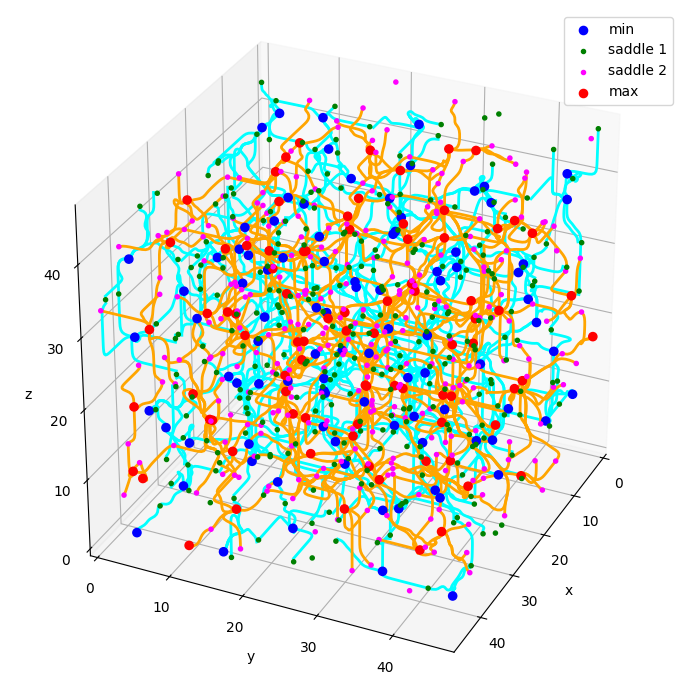

In [11]:
import matplotlib.pyplot as plt
import numpy as np

node_xyz = np.array([n.pos for n in msc1_s_int.nodes.values()])
node_dim = np.array([n.dim for n in msc1_s_int.nodes.values()])
arc_lines = [np.asarray(a.geom) for a in msc1_s_int.arcs if len(a.geom) >= 2]

arc_lines_max_sad2 = [
    np.asarray(a.geom)
    for a in filter_arcs_by_dims(msc1_s_int, src_dims=(3,), dst_dims=(2,), undirected=True)
    if len(a.geom) >= 2
]

arc_lines_sad1_min = [
    np.asarray(a.geom)
    for a in filter_arcs_by_dims(msc1_s_int, src_dims=(0,), dst_dims=(1,), undirected=True)
    if len(a.geom) >= 2
]

f_sigma = n_grid/scale/2
arc_lines_max_sad2_sm = [smooth_polyline_gaussian(L, sigma=f_sigma, n_samples=None)
                         for L in arc_lines_max_sad2]
arc_lines_sad1_min_sm = [smooth_polyline_gaussian(L, sigma=f_sigma, n_samples=None)
                            for L in arc_lines_sad1_min]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")

# arcs black
for L in arc_lines_sad1_min_sm:
    ax.plot(L[:,0], L[:,1], L[:,2], color="cyan", linewidth=2, alpha=1)
    
for L in arc_lines_max_sad2_sm:
    ax.plot(L[:,0], L[:,1], L[:,2], color="orange", linewidth=2, alpha=1)

# nodes: min blue, saddles green, max red
mins = node_xyz[node_dim == 0]
sads_1 = node_xyz[(node_dim == 1)]
sads_2 = node_xyz[(node_dim == 2)]
maxs = node_xyz[node_dim == 3]

if len(mins): ax.scatter(mins[:,0], mins[:,1], mins[:,2], c="blue",  s=35, label="min", marker="o", alpha=1)
if len(sads_1): ax.scatter(sads_1[:,0], sads_1[:,1], sads_1[:,2], c="green", s=35, label="saddle 1", marker=".", alpha=1)
if len(sads_2): ax.scatter(sads_2[:,0], sads_2[:,1], sads_2[:,2], c="magenta", s=35, label="saddle 2", marker=".", alpha=1)
if len(maxs): ax.scatter(maxs[:,0], maxs[:,1], maxs[:,2], c="red",   s=35, label="max", marker="o", alpha=1)

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.legend()
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1, n_grid]); ax.set_ylim([-1, n_grid]); ax.set_zlim([-1, n_grid])
ax.view_init(elev=30., azim=25)
plt.tight_layout()
plt.show()
